In [1]:
import os

import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl

import json
import powerlaw
import imageio
import warnings
import pickle

from fa2 import ForceAtlas2

# create number for each group to allow use of colormap
from itertools import count

In [2]:
%run Utilyties.ipynb

# Inizializzazione della rete da file

In [3]:
data = read_data('../data/final/data_complete.json')

G = init_network(data)

Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  29863
* TOT Quote =  1187
* TOT Mentions =  57896
* TOT Reply =  3000




In [4]:
G0 = giant_component(G)

## Analisi della rete 

In [5]:
network_node_edge(G, 'G')

La rete G ha:

* Numero di nodi =  16675
* Numero di Edge =  52373


In [6]:
for usr in list(G.nodes.data()):
    if 'classification' not in usr[1]:
        usr[1]['classification'] = 0
    if 'vip' not in usr[1]:
        usr[1]['vip'] = -1

# Analisi delle Echochambers

In [7]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [935]:
# per generare le posizioni utilizzate per la definizione della retta tra una echo chamber e l'altra 
# utilizzare il file data.pkl (cella sotto)

# positions = forceatlas2.forceatlas2_networkx_layout(G0, pos=None, iterations=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:59<00:00,  1.11it/s]

BarnesHut Approximation  took  122.46  seconds
Repulsion forces  took  763.26  seconds
Gravitational forces  took  1.31  seconds
Attraction forces  took  1.34  seconds
AdjustSpeedAndApplyForces step  took  4.87  seconds


In [8]:
# salvataggio di positions in un file

#a_file = open("data.pkl", "wb")
#pickle.dump(positions, a_file)
#a_file.close()

# caricamento di positions dal file 

a_file = open("data.pkl", "rb")
positions = pickle.load(a_file)

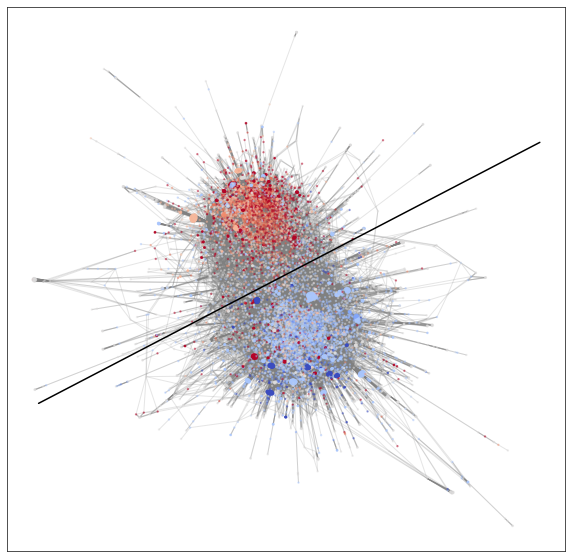

In [9]:
from matplotlib.pyplot import figure
sns.set_style(style='white')
figure(figsize=(10, 10))

nx.draw_networkx_nodes(G0, positions, node_size=2, with_labels=False, 
                       node_color=[G0.nodes[node]['classification'] for node in G0.nodes()], 
                       cmap = 'coolwarm', alpha=0.4)
nx.draw_networkx_edges(G0, positions, edge_color="grey", alpha=0.2)

#plt.axhline(0, color='black')
#plt.axvline(0, color='black')
x = np.linspace(-3000, 3000, 5)
plt.plot(x, 0.6*x+80, linestyle='-', color='black')
plt.axis('on')
plt.show()


In [10]:
for p in positions:
    if (positions[p][1] - 0.6*positions[p][0] - 80 > 0):
        G0.nodes[p]['echo_chamber'] = 'red'
    else:
        G0.nodes[p]['echo_chamber'] = 'blue'

In [12]:
red = 0
blue = 0

for node in G0.nodes():
    if G0.nodes[node]['echo_chamber'] == 'red':
        red += 1
    else:
        blue += 1
        
print(f"Dimensione delle echo chambers:\n\nRed: {red}\nBlue: {blue}")

Dimensione delle echo chambers:

Red: 6812
Blue: 9262


In [13]:
H_red = G0.subgraph([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='red'])
H_blue = G0.subgraph([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='blue'])

In [14]:
H0_red = giant_component(H_red)
H0_blue = giant_component(H_blue)

In [15]:
print(f"Nodi scollegati echo chamber Red: {H_red.number_of_nodes() - H0_red.number_of_nodes()}")
print(f"Nodi scollegati echo chamber Blue: {H_blue.number_of_nodes() - H0_blue.number_of_nodes()}")

Nodi scollegati echo chamber Red: 64
Nodi scollegati echo chamber Blue: 0


In [19]:
pos_red = nx.spring_layout(H0_red)

In [20]:
pos_blue = nx.spring_layout(H0_blue)

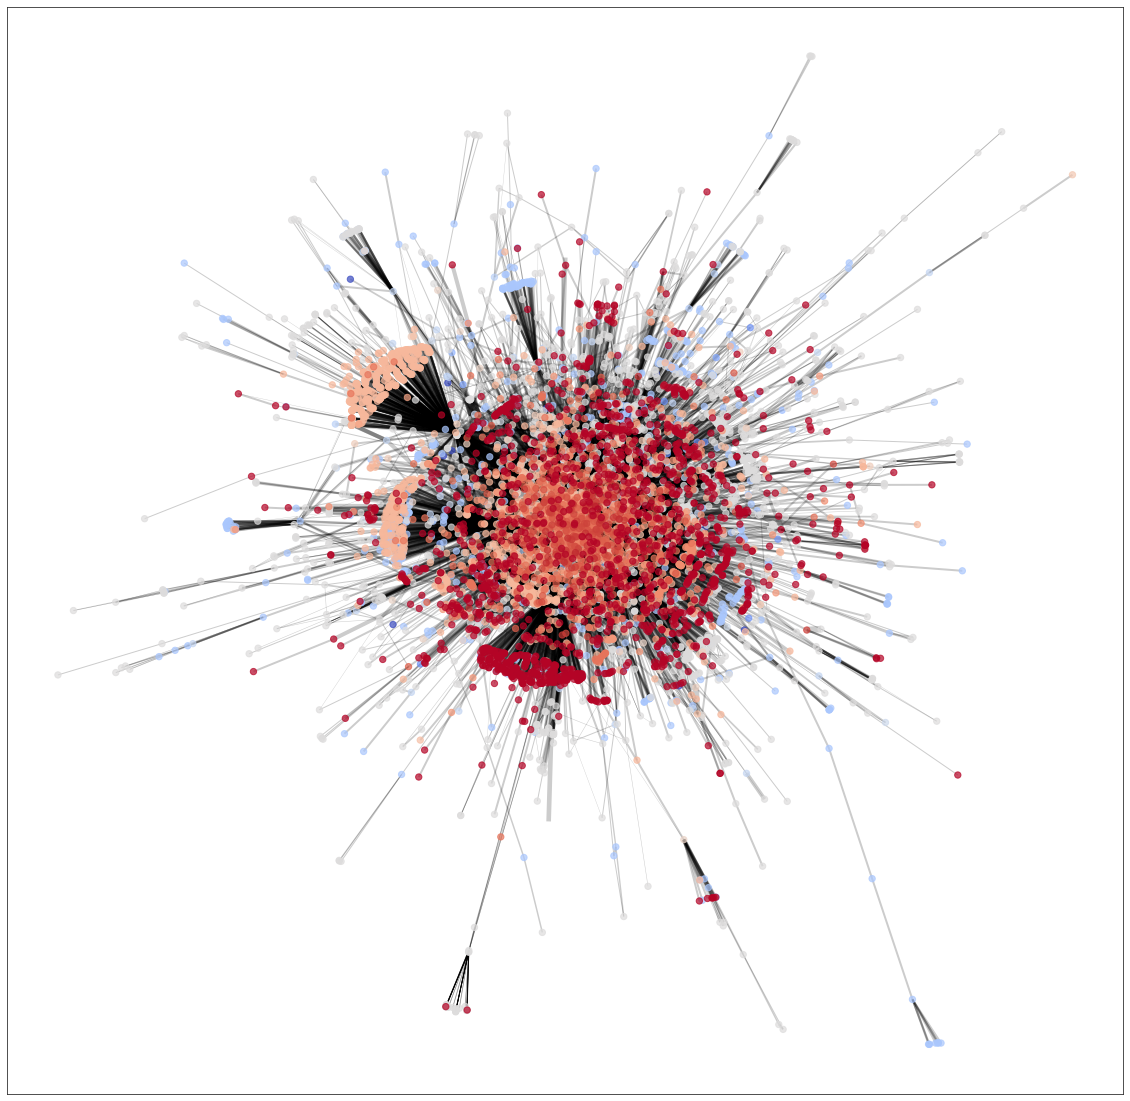

In [34]:
plt.figure(figsize = (20,20))

widths = nx.get_edge_attributes(H0_red, 'weight')
tmp = nx.get_node_attributes(H0_red, 'classification')
tmp = {k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
low, *_, high = sorted(tmp.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap = mpl.cm.coolwarm)

'''graf = nx.draw(
    H0_red,
    nodelist=tmp,
    pos = pos_red,
    node_color = [mapper.to_rgba(i) for i in sorted(tmp.values())],
    node_size = 10,
    edge_width = list(widths.values())
)'''

nx.draw_networkx_nodes(H0_red,
                       pos_red,
                       nodelist=tmp,
                       node_color = [mapper.to_rgba(i) for i in sorted(tmp.values())],
                       node_size = 40,
                       alpha=0.7)

nx.draw_networkx_edges(H0_red,
                       pos_red,
                       edgelist = widths.keys(),
                       width = list(widths.values()),
                       edge_color = 'black',
                       alpha=0.2)


plt.show()

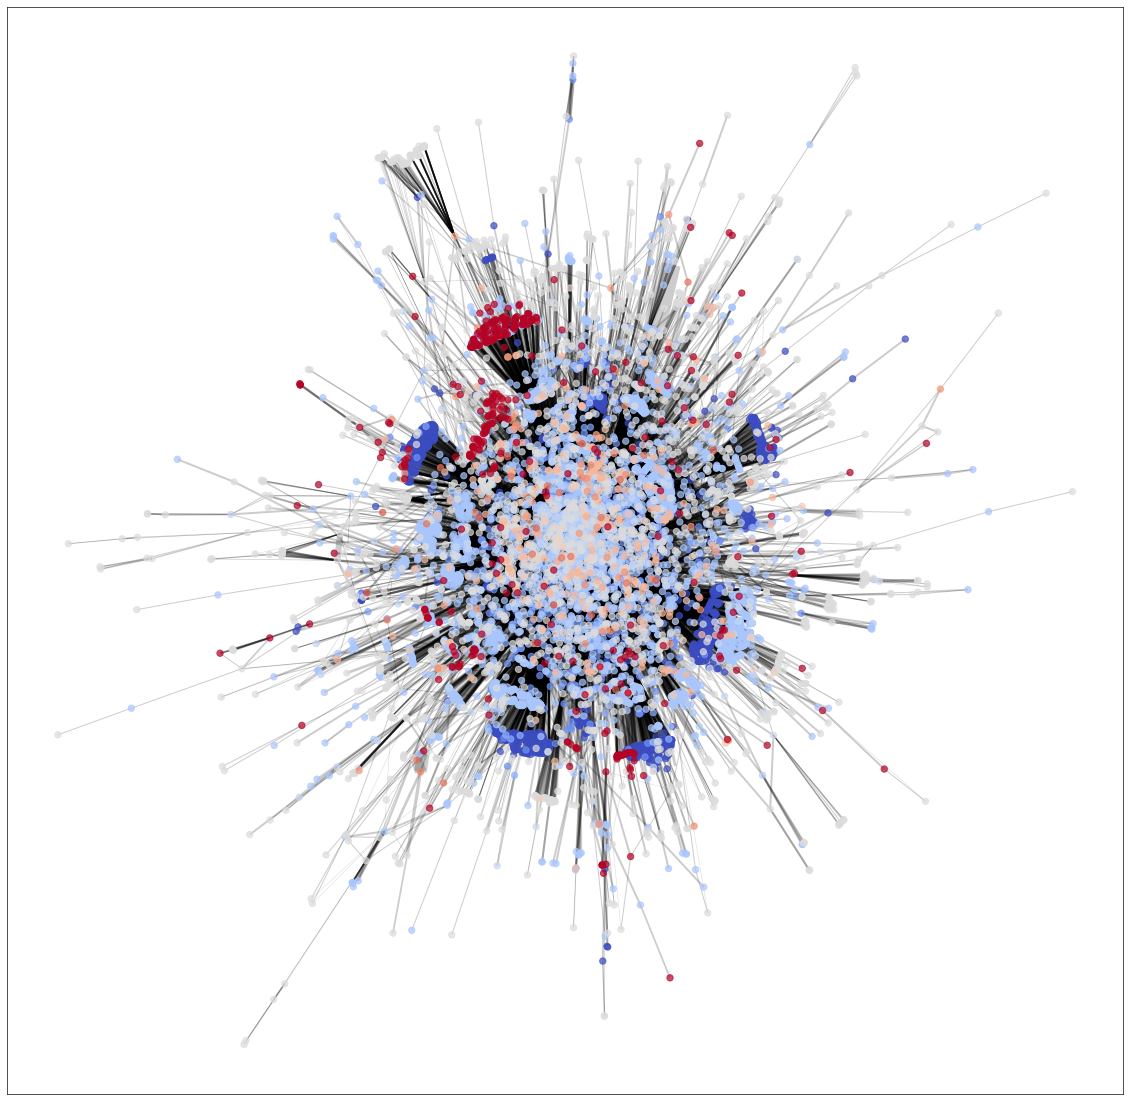

In [33]:
plt.figure(figsize = (20,20))

widths = nx.get_edge_attributes(H0_blue, 'weight')
tmp = nx.get_node_attributes(H0_blue, 'classification')
tmp = {k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
low, *_, high = sorted(tmp.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap = mpl.cm.coolwarm)

nx.draw_networkx_nodes(H0_blue,
                       pos_blue,
                       nodelist=tmp,
                       node_color = [mapper.to_rgba(i) for i in sorted(tmp.values())],
                       node_size = 40,
                       alpha=0.7)

nx.draw_networkx_edges(H0_blue,
                       pos_blue,
                       edgelist = widths.keys(),
                       width = list(widths.values()),
                       edge_color = 'black',
                       alpha=0.2)


plt.show()

In [137]:
network_info(H0_red, 'Echo chamber - red')

Informazioni sulla rete Echo chamber - red:
 Numero di nodi: 	6748
 Numero di link: 	21163

 Grado medio: 		6.272377000592768
 Transitività: 		0.017872487353660593
 Average clustering: 	0.25087809812159784

 Numero di componenti connesse: 	1
 Diametro: 	11

 Densità: 	0.0009296542167767553

Lunghezza media del cammino più breve 3.7140285141988065


In [35]:
def percentage(part, whole):
  percentage = 100 * float(part)/float(whole)
  return str(round(percentage,2)) + "%"

In [36]:
def echo_chamber_profiling(g_echo):
    # percentuale di pro
    pros = len([x for x,y in g_echo.nodes(data=True) if y['classification']<-0.5])
    cons = len([x for x,y in g_echo.nodes(data=True) if y['classification']>0.5])
    neutrals = (g_echo.number_of_nodes() - pros - cons)
    
    print(f"Utenti a favore: {percentage(pros, g_echo.number_of_nodes())}\nUtenti contrari: {percentage(cons, g_echo.number_of_nodes())}%\nUtenti neutri o non classificabili: {percentage(neutrals, g_echo.number_of_nodes())}%")
    #return pros, cons, neutrals

In [37]:
echo_chamber_profiling(H0_red)

Utenti a favore: 10.42%
Utenti contrari: 64.75%%
Utenti neutri o non classificabili: 24.84%%


In [138]:
network_info(H0_blue, 'Echo chamber - blue')

Informazioni sulla rete Echo chamber - blue:
 Numero di nodi: 	9262
 Numero di link: 	27573

 Grado medio: 		5.954005614338156
 Transitività: 		0.011811854710052598
 Average clustering: 	0.29412270408754554

 Numero di componenti connesse: 	1
 Diametro: 	11

 Densità: 	0.0006429117389415998

Lunghezza media del cammino più breve 3.8561586819864004


In [38]:
echo_chamber_profiling(H0_blue)

Utenti a favore: 67.11%
Utenti contrari: 8.44%%
Utenti neutri o non classificabili: 24.44%%


In [39]:
print(f"Numero di edges tra le due echo chambers: {G0.number_of_edges() - (H0_red.number_of_edges()+H0_blue.number_of_edges())} ({round((((G0.number_of_edges() - (H0_red.number_of_edges()+H0_blue.number_of_edges()))/G0.number_of_edges())*100), 2)}%)")

Numero di edges tra le due echo chambers: 3196 (6.15%)


# Hub e vip

In [40]:
from operator import itemgetter, attrgetter

# find node with largest degree
node_and_degree = G.degree()

hubs = sorted(node_and_degree, key=itemgetter(1), reverse=True)
vip = nx.get_node_attributes(G,'vip')
classif = nx.get_node_attributes(G,'classification')

In [41]:
def extr_real_list(l_hub):
    real_hub = []
    for u in l_hub: 
        for t in data:
            if u==t['user']:
                real_hub.append(u)
    return set(real_hub)

In [111]:
l_vip_red = []
l_vip_blue = []

for h in hubs[:5000]:
    if vip[h[0]]==2:
        if H0_red.has_node(h[0]):
            l_vip_red.append(h[0])
            print(f"RED {h[0]} \tc: {classif[h[0]]} - \tgrado: {h[1]} \tvip: {vip[h[0]]} ")
        else:
            l_vip_blue.append(h[0])
            print(f"RED {h[0]} \tc: {classif[h[0]]} - \tgrado: {h[1]} \tvip: {vip[h[0]]} ")

RED repubblica 	c: 0 - 	grado: 1609 	vip: 2 
RED lefrasidiosho 	c: 1.0 - 	grado: 860 	vip: 2 
RED Vivo_Azzurro 	c: 0 - 	grado: 698 	vip: 2 
RED robertosaviano 	c: -3.0 - 	grado: 651 	vip: 2 
RED Azzurri 	c: 0 - 	grado: 634 	vip: 2 
RED espressonline 	c: 0 - 	grado: 387 	vip: 2 
RED HuffPostItalia 	c: 0 - 	grado: 375 	vip: 2 
RED La7tv 	c: 0 - 	grado: 356 	vip: 2 
RED chiellini 	c: 0 - 	grado: 345 	vip: 2 
RED porquetendencia 	c: 0 - 	grado: 304 	vip: 2 
RED pdnetwork 	c: 0 - 	grado: 243 	vip: 2 
RED EnricoLetta 	c: 0 - 	grado: 231 	vip: 2 
RED robymancio 	c: 0 - 	grado: 215 	vip: 2 
RED Corriere 	c: 0 - 	grado: 198 	vip: 2 
RED fanpage 	c: -0.8571428571428571 - 	grado: 189 	vip: 2 
RED WiredItalia 	c: 0 - 	grado: 180 	vip: 2 
RED Repubblica 	c: 0 - 	grado: 161 	vip: 2 
RED matteosalvinimi 	c: 0 - 	grado: 112 	vip: 2 
RED RaiSport 	c: -1.0 - 	grado: 108 	vip: 2 
RED ClaMarchisio8 	c: 0 - 	grado: 107 	vip: 2 
RED GiorgiaMeloni 	c: 0 - 	grado: 94 	vip: 2 
RED bonucci_leo19 	c: 0 - 	grado:

In [43]:
print(extr_real_list(l_vip_red))
print(extr_real_list(l_vip_blue))

{'Adnkronos', 'lefrasidiosho', 'CorSport', 'RaiSport'}
{'robertosaviano', 'fanpage', 'FranAltomare', 'ilfoglio_it', 'rtl1025', 'Gazzetta_it', 'rossbrescia', 'TristeMietitore'}


In [44]:
l_hub_red = []
l_hub_blue = []

for h in hubs[:34]: #2%° dei nodi in base al grado
    if H0_red.has_node(h[0]):
        print(f"RED {h[0]} \tc: {classif[h[0]]} - \tgrado: {h[1]} \tvip: {vip[h[0]]} ")
        l_hub_red.append(h[0])
    else:    
    #elif H0_blue.has_node(h[0]):
        print(f"BLUE {h[0]} \tc: {classif[h[0]]} - \tgrado: {h[1]} \tvip: {vip[h[0]]}")
        l_hub_blue.append(h[0])
        

BLUE repubblica 	c: 0 - 	grado: 1609 	vip: 2
BLUE PBerizzi 	c: -1.0 - 	grado: 1252 	vip: 1
BLUE feltrinellied 	c: 0 - 	grado: 1192 	vip: 1
RED Giorgiolaporta 	c: 1.6666666666666667 - 	grado: 1100 	vip: 1 
RED fratotolo2 	c: 2.2 - 	grado: 892 	vip: 0 
RED IlPrimatoN 	c: 3.0 - 	grado: 891 	vip: 1 
RED lefrasidiosho 	c: 1.0 - 	grado: 860 	vip: 2 
RED FedericoRampini 	c: 0 - 	grado: 788 	vip: 1 
RED Gianmar26145917 	c: 2.538095238095238 - 	grado: 773 	vip: 0 
BLUE MarcoNoel19 	c: -1.0 - 	grado: 740 	vip: 0
RED Vivo_Azzurro 	c: 0 - 	grado: 698 	vip: 2 
BLUE robertosaviano 	c: -3.0 - 	grado: 651 	vip: 2
RED Azzurri 	c: 0 - 	grado: 634 	vip: 2 
RED Azzurri_Ar 	c: 0 - 	grado: 629 	vip: 1 
BLUE ProfCampagna 	c: -3.0 - 	grado: 577 	vip: 1
BLUE manginobrioches 	c: -3.0 - 	grado: 555 	vip: 1
RED LeonardoPanetta 	c: 1.0 - 	grado: 548 	vip: 0 
BLUE TendenzaPerche 	c: 0.8333333333333334 - 	grado: 547 	vip: 0
BLUE FIGC 	c: 0 - 	grado: 461 	vip: 1
BLUE JFSebastian146 	c: -0.926798825256975 - 	grado: 44

In [45]:
real_hub_blue = extr_real_list(l_hub_blue)
real_hub_red = extr_real_list(l_hub_red)

In [46]:
real_hub_blue

{'AlbertoLetizia2',
 'JFSebastian146',
 'MarcoNoel19',
 'PBerizzi',
 'ProfCampagna',
 'TendenzaPerche',
 'ValeriaParrell2',
 'manginobrioches',
 'maurobiani',
 'perchetendenza',
 'pietroraffa',
 'robertosaviano'}

In [47]:
real_hub_red

{'Gianmar26145917',
 'Giorgiolaporta',
 'GiuseppePalma78',
 'IlPrimatoN',
 'LeonardoPanetta',
 'fratotolo2',
 'lefrasidiosho',
 'strange_days_82'}

In [48]:
real_hubs = set.union(real_hub_blue, real_hub_red)

## Domanda: come l'intervento degli hub indirizza la conversazione

In [49]:
ranges = [
    ['2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14'], # Italia - Turchia
    ['2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19'], # Italia - Svizzera
    ['2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24'], # Italia - Galles
    ['2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29'], # Italia - Austria
    ['2021-06-30', '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04'], # Italia - Belgio
    ['2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09'], # Italia - Spagna
    ['2021-07-10', '2021-07-11', '2021-07-12'],                             # Italia - Inghilterra
]
snapshots = get_snapshot("../data/final/data_complete.json", ranges)



In [50]:
def create_df(G, T): 
    nx.set_node_attributes(G, 0, "neighbours_opinion")
    
    for node in G.nodes():
        for n in(G.neighbors(node)):
            G.nodes[node]['neighbours_opinion'] += G.nodes[n]["classification"]
        if (G.degree[node] != 0): 
            G.nodes[node]['neighbours_opinion'] = G.nodes[node]['neighbours_opinion']/G.degree[node]
        else:
            G.nodes[node]['neighbours_opinion'] = G.nodes[node]['classification']
        
    n_class = {}

    for node in G.nodes():
        n_class[node] = [G.nodes[node]['classification']]
        n_class[node].append(G.nodes[node]['neighbours_opinion'])

    df_class = pd.DataFrame.from_dict(n_class, orient='index',
                           columns=['opinion','neighbours_opinion'])

    df_class["class"] = np.where(df_class["opinion"]>0.5, 'contro', np.where(df_class["opinion"]<-0.5, 'pro', 'neutro'))
    
    #sns.jointplot(data = df_class, x = "opinion", y = "neighbours_opinion", kind = "kde")
    
    g = sns.kdeplot(data = df_class,  x = "opinion", y = "neighbours_opinion", 
                fill=True, thresh=0, levels=100, cmap="CMRmap") #ax=axes[T]) #o mako
    
    g.set(xlim=(-3, 3), ylim=(-3, 3))
    
    r, p = scipy.stats.pearsonr(df_class['opinion'], df_class['neighbours_opinion'])
    #print(r, p, G.number_of_nodes(), '\n\n')
    
    G_tmp = G.copy()
    ass_mix.append(ASS_mix(G_tmp))
    
    g.text(x=0.02, y=0.98, transform = g.transAxes, s="Pearson: %f" % r,\
        fontsize=14, verticalalignment='top', horizontalalignment='left', color='white')
    g.text(x=0.02, y=0.94, transform = g.transAxes, s="Assortative Mixing: %f" % ass_mix[T],\
        fontsize=14, verticalalignment='top', horizontalalignment='left', color='white')
    
    # create file name and append it to a list
    filename = f'Density{T}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename, transparent=True)
    plt.close()
   
    

In [51]:
def create_faction(G):
    for node in G.nodes():
        if G.nodes[node]['classification'] <= 0.5 and G.nodes[node]['classification'] >= -0.5:
            G.nodes[node]['classification'] = 0
        elif G.nodes[node]['classification'] > 0.5:
            G.nodes[node]['classification'] = 1
        else:
            G.nodes[node]['classification'] = -1

In [52]:
def ASS_mix(G):
    create_faction(G)
    return nx.attribute_assortativity_coefficient(G, "classification")

In [1043]:
G=nx.Graph()
T = 0
ass_mix = []
filenames = []   

#f, axes = plt.subplots(3, 1, figsize=(10,70))
#f, ax = plt.subplots(figsize=(10,10))

for snap in snapshots:
    build_network(snap, G)
    for usr in list(G.nodes.data()):
        if 'classification' not in usr[1]:
            usr[1]['classification'] = 0
        if 'vip' not in usr[1]:
            usr[1]['vip'] = -1
    create_df(G, T)
    T += 1
    

'''
# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        writer.append_data(image) # per allungare il tempo
        writer.append_data(image) # per allungare il tempo
        
# remove files
for filename in set(filenames):
    os.remove(filename) 
'''
  

Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  53
* TOT Quote =  4
* TOT Mentions =  113
* TOT Reply =  5


Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  19
* TOT Quote =  6
* TOT Mentions =  24
* TOT Reply =  0


Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  3695
* TOT Quote =  161
* TOT Mentions =  7443
* TOT Reply =  394


Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  23221
* TOT Quote =  874
* TOT Mentions =  44420
* TOT Reply =  2087


Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  2316
* TOT Quote =  109
* TOT Mentions =  4773
* TOT Reply =  442


Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  174
* TOT Quote =  10
* TOT Mentions =  495
* TOT Reply =  16


Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  385
* TOT Quote =  23
* TOT Mentions =  628
* TOT Reply =  56




"\n# build gif\nwith imageio.get_writer('mygif.gif', mode='I') as writer:\n    for filename in filenames:\n        image = imageio.imread(filename)\n        writer.append_data(image)\n        writer.append_data(image) # per allungare il tempo\n        writer.append_data(image) # per allungare il tempo\n        \n# remove files\nfor filename in set(filenames):\n    os.remove(filename) \n"

In [53]:
G = nx.Graph()
c = nx.Graph()

c_red = nx.Graph()
c_blue = nx.Graph()

r_hubs = 0
b_hubs = 0
n_hubs = 0

l_r_hubs = []
l_b_hubs = []
l_n_hubs = []

r_mean_size = []
b_mean_size = []
mean_size = []

perc_net = []
r_perc_ego = []
b_perc_ego = []

time = 1

for snap, dates in zip(snapshots, ranges):
    
    print(f"--- Network dal: {dates[0]} al {dates[-1]} (Tempo {time})--- \n")
    build_network(snap, G)
    
    for node in real_hubs:
        if G.has_node(node):
            n_hubs += 1
            node_ego = nx.ego_graph(G, node)
            c = nx.compose(c, node_ego)
            if node in real_hub_red:
                c_red = nx.compose(c_red, node_ego)
                r_hubs += 1
            if node in real_hub_blue:
                c_blue = nx.compose(c_blue, node_ego)
                b_hubs += 1
                
    l_r_hubs.append(r_hubs)
    l_b_hubs.append(b_hubs)
    l_n_hubs.append(n_hubs)
    
    r_mean_size.append(c_red.number_of_nodes()/r_hubs)
    b_mean_size.append(c_blue.number_of_nodes()/b_hubs)
    mean_size.append(c.number_of_nodes()/n_hubs)
    
    perc_net.append(round(c.number_of_nodes()/G.number_of_nodes()*100, 2))
    r_perc_ego.append(round(c_red.number_of_nodes()/c.number_of_nodes()*100, 2))
    b_perc_ego.append(round(c_blue.number_of_nodes()/c.number_of_nodes()*100, 2))
    
    print(f"Al tempo {time}:\n\tNumero di hubs: {n_hubs}" +
          f"\n\tNumero di nodi delle ego-network di tutti gli hubs: {c.number_of_nodes()} - il {round(c.number_of_nodes()/G.number_of_nodes()*100, 2)}% della rete")
    
    print(f"\tNumero di hubs rossi: {r_hubs}\n\tNumero di nodi della ego-network degli hubs rossi {c_red.number_of_nodes()}" + 
          f" - il {round(c_red.number_of_nodes()/G.number_of_nodes()*100, 2)}% della rete\n" +
          f"\t - il {round(c_red.number_of_nodes()/c.number_of_nodes()*100, 2)}% delle ego-network di tutti gli hubs\n")
    
    print(f"\tNumero di hubs blue: {b_hubs}\n\tNumero di nodi della ego-network degli hubs blu {c_blue.number_of_nodes()}" + 
          f" - il {round(c_blue.number_of_nodes()/G.number_of_nodes()*100, 2)}% della rete\n" +
          f"\t- il {round(c_blue.number_of_nodes()/c.number_of_nodes()*100, 2)}% delle ego-network di tutti gli hubs\n\n")
    
    r_hubs = 0
    b_hubs = 0
    n_hubs = 0
    time += 1

--- Network dal: 2021-06-10 al 2021-06-14 (Tempo 1)--- 

Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  53
* TOT Quote =  4
* TOT Mentions =  113
* TOT Reply =  5


Al tempo 1:
	Numero di hubs: 4
	Numero di nodi delle ego-network di tutti gli hubs: 14 - il 15.56% della rete
	Numero di hubs rossi: 3
	Numero di nodi della ego-network degli hubs rossi 10 - il 11.11% della rete
	 - il 71.43% delle ego-network di tutti gli hubs

	Numero di hubs blue: 1
	Numero di nodi della ego-network degli hubs blu 4 - il 4.44% della rete
	- il 28.57% delle ego-network di tutti gli hubs


--- Network dal: 2021-06-15 al 2021-06-19 (Tempo 2)--- 

Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  19
* TOT Quote =  6
* TOT Mentions =  24
* TOT Reply =  0


Al tempo 2:
	Numero di hubs: 5
	Numero di nodi delle ego-network di tutti gli hubs: 19 - il 15.97% della rete
	Numero di hubs rossi: 3
	Numero di nodi della ego-network degli hubs rossi 10 - il 8.4% della rete
	 - il 52.63% delle eg

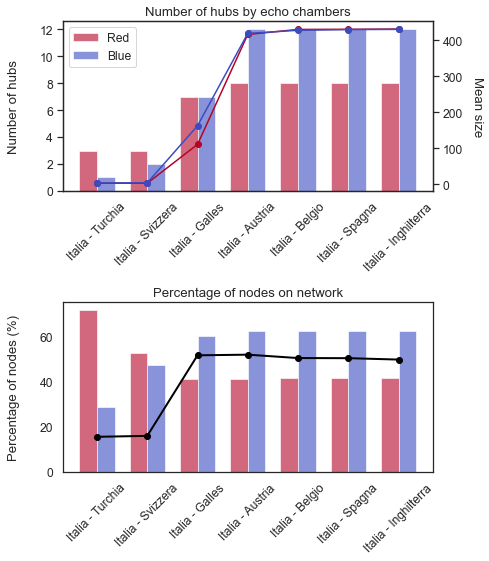

In [1045]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Italia - Turchia", "Italia - Svizzera", "Italia - Galles", "Italia - Austria", "Italia - Belgio", "Italia - Spagna", "Italia - Inghilterra"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize=(7,8))

ax[0].bar(x - width/2, l_r_hubs, width, color = '#b40426', alpha=.6, label='Red')
ax[0].bar(x + width/2, l_b_hubs, width, color = '#3b4cc0', alpha=.6, label='Blue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Number of hubs', labelpad=20)
ax[0].set_title('Number of hubs by echo chambers')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, rotation=45)
ax[0].legend()

ax2 = ax[0].twinx()
ax2.plot(ax[0].get_xticks(),
         r_mean_size,
         linestyle='-',
         marker='o', color = '#b40426', linewidth=1.5, label='Red')

ax2.plot(ax[0].get_xticks(),
         b_mean_size,
         linestyle='-',
         marker='o', color = '#3b4cc0', linewidth=1.5, label='Blue')
ax2.set_ylabel('Mean size', rotation=-90, labelpad=20)

#leg = ax2.legend()
#for line in leg.get_lines():
    #line.set_linewidth(6.0)

#ax[0].bar_label(rects1, padding=3)
#ax[0].bar_label(rects2, padding=3)

ax[1].bar(x - width/2, r_perc_ego, width, color = '#b40426', alpha=.6, label='Red')
ax[1].bar(x + width/2, b_perc_ego, width, color = '#3b4cc0', alpha=.6, label='Blue')
ax[1].plot(perc_net,
         linestyle='-',
         marker='o', color='black', linewidth=2.0)

ax[1].set_ylabel('Percentage of nodes (%)', labelpad=20)
ax[1].set_title('Percentage of nodes on network')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, rotation=45)

fig.tight_layout()
plt.show()

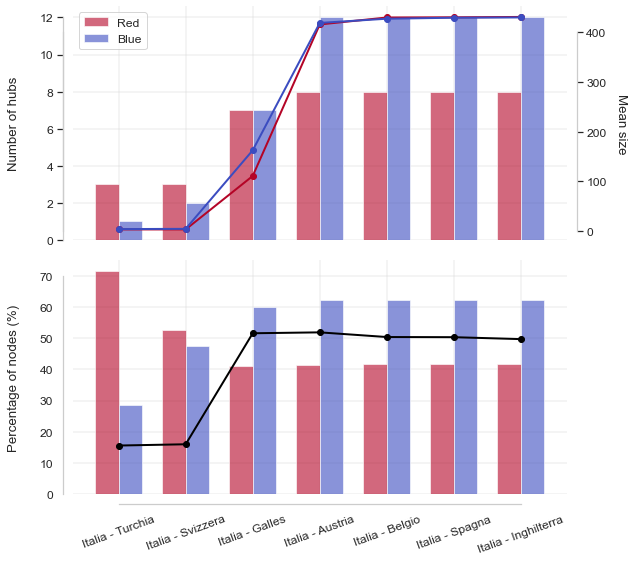

In [96]:
labels = ["Italia - Turchia", "Italia - Svizzera", "Italia - Galles", "Italia - Austria", "Italia - Belgio", "Italia - Spagna", "Italia - Inghilterra"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

sns.set(rc={'figure.figsize':(9,8), "lines.linewidth": 0.9, "grid.linewidth": 0.4}, font_scale=1.1)
sns.set_style("whitegrid")

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].bar(x - width/2, l_r_hubs, width, color = '#b40426', alpha=.6, label='Red')
ax[0].bar(x + width/2, l_b_hubs, width, color = '#3b4cc0', alpha=.6, label='Blue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Number of hubs', labelpad=20)
#ax[0].set_title('Number of hubs by echo chambers')
ax[0].set_xticks(x)
ax[0].legend()

ax2 = ax[0].twinx()

ax2.plot(r_mean_size,
         linestyle='-',
         marker='o', color = '#b40426', linewidth=2, label='Red')
ax2.plot(b_mean_size,
         linestyle='-',
         marker='o', color = '#3b4cc0', linewidth=2, label='Blue')

ax2.set_ylabel('Mean size', rotation=-90, labelpad=20)
ax2.xaxis.grid(False) # Show the vertical gridlines
ax2.yaxis.grid(False) # Hide the horizontal gridlines

#ax[0].bar_label(rects1, padding=3)
#ax[0].bar_label(rects2, padding=3)

ax[1].bar(x - width/2, r_perc_ego, width, color = '#b40426', alpha=.6, label='Red')
ax[1].bar(x + width/2, b_perc_ego, width, color = '#3b4cc0', alpha=.6, label='Blue')
ax[1].plot(perc_net,
         linestyle='-',
         marker='o', color='black', linewidth=2.0)

ax[1].set_ylabel('Percentage of nodes (%)', labelpad=20)
#ax[1].set_title('Percentage of nodes on network')
ax[1].set_xticks(x)

sns.despine(top=True, right=True, left=False, bottom=True, offset=10, trim=True, ax = ax[0])
sns.despine(top=True, right=False, left=False, bottom=True, offset=10, trim=True, ax = ax2)
sns.despine(offset=10, trim=True, ax = ax[1])

ax[1].set_xticklabels(labels, rotation=20)

fig.tight_layout()
plt.show()

# Centrality & Assortative Mixing

In [97]:
import matplotlib.colors as mcolors

# Support function to plot networks (only small graphs)
def draw_net(G, pos, measures, measure_name):
    
    plt.figure(figsize=(20,20))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=1, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    #labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

## Degree Centrality

In [112]:
degrees_red = dict(H0_red.degree()) # compute the degree of a set of nodes (if specified).

In [127]:
top_score_print(15, degrees_red, order=True)

Giorgiolaporta 	 1082
IlPrimatoN 	 885
fratotolo2 	 879
lefrasidiosho 	 820
FedericoRampini 	 781
Gianmar26145917 	 765
LeonardoPanetta 	 545
Vivo_Azzurro 	 545
Azzurri 	 506
Azzurri_Ar 	 501
strange_days_82 	 367
GiuseppePalma78 	 336
EsercitoCrucian 	 316
ItalicaTestudo 	 220
pdnetwork 	 206


In [114]:
degrees_blue = dict(H0_blue.degree()) # compute the degree of a set of nodes (if specified).

In [128]:
top_score_print(15, degrees_blue, order=True)

repubblica 	 1413
PBerizzi 	 1079
feltrinellied 	 1047
MarcoNoel19 	 740
ProfCampagna 	 566
robertosaviano 	 541
manginobrioches 	 533
TendenzaPerche 	 529
ValeriaParrell2 	 436
maurobiani 	 424
kiapasqualini 	 395
FIGC 	 383
espressonline 	 381
pietroraffa 	 361
AlbertoLetizia2 	 361


## Closeness centrality

Measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, <b>the more central a node is, the closer it is to all other nodes</b>.

In [117]:
closeness_red = nx.closeness_centrality(H0_red) # compute the closeness centraliry of all nodes

In [129]:
top_score_print(15, closeness_red, order=True)

fratotolo2 	 0.4183148366296733
LPincia 	 0.41405339061061674
IlPrimatoN 	 0.4121060346933789
adrianobusolin 	 0.4095793116008013
Patriota_ITA_ 	 0.40469049904030713
jobwithinternet 	 0.4017267043763025
Giorgiolaporta 	 0.4016310494672302
Gianmar26145917 	 0.4013443578609244
aspettaaspetta 	 0.40089126559714794
2014Monaco 	 0.3997985304574544
elena_elnmrl15 	 0.3972562411681583
attilascuola 	 0.3969991173874669
Vivo_Azzurro 	 0.3950002927229085
FedericoRampini 	 0.39391639420831387
LuceChiara1211 	 0.3930214947282577


In [ ]:
closeness_blue = nx.closeness_centrality(H0_blue) # compute the closeness centraliry of all nodes

In [130]:
top_score_print(15, closeness_blue, order=True)

JFSebastian146 	 0.43124563445867287
repubblica 	 0.39425287356321836
PBerizzi 	 0.3812366211098304
Nena_Nina_Schi 	 0.38017241379310346
pirex70 	 0.3777378961536893
LilianaArmato 	 0.3774146222185997
anubi_matt 	 0.37666246390368896
feltrinellied 	 0.3760201388606927
v_m_a_x_i_m_o 	 0.3754865390853065
mgabrielladavid 	 0.3730363328768227
1969Tonger 	 0.37294619845360827
FIGC 	 0.37276606021574626
XYZxyzY6 	 0.3712418824661268
Lucia05149332 	 0.37030668959174695
blusewillis1 	 0.37024747131491625


## Eigenvector centrality

Measure of the <b>influence</b> of a node in a network.

In [ ]:
eigenvector_red = nx.eigenvector_centrality(H0_red)

In [131]:
top_score_print(15, eigenvector_red, order=True)

fratotolo2 	 0.2953907670929719
IlPrimatoN 	 0.2864610053788301
FedericoRampini 	 0.23278904295223374
Gianmar26145917 	 0.21110335963293256
Giorgiolaporta 	 0.2030472243542563
Vivo_Azzurro 	 0.18412659500076117
Azzurri 	 0.17549155924607876
Azzurri_Ar 	 0.17498360795750764
ItalicaTestudo 	 0.09912780121391197
strange_days_82 	 0.09799964956309648
EnricoLetta 	 0.08829037453464295
LeonardoPanetta 	 0.07871728286939363
jobwithinternet 	 0.07459679579701275
pdnetwork 	 0.07458240065831565
2014Monaco 	 0.07305347951672105


In [ ]:
eigenvector_blue = nx.eigenvector_centrality(H0_blue)

In [132]:
top_score_print(15, eigenvector_blue, order=True)

repubblica 	 0.386428135117358
PBerizzi 	 0.30404326120991265
feltrinellied 	 0.29359565806258964
maurobiani 	 0.14986153408436367
espressonline 	 0.12812176088786523
La7tv 	 0.12440371893119531
ilmanifesto 	 0.12317687478578933
isiciliani 	 0.12247813178462785
aznonviolenta 	 0.12247813178462785
nonsonpago1 	 0.08397983284616192
anubi_matt 	 0.0788752954168786
_Nico_Piro_ 	 0.07469530948183692
mgabrielladavid 	 0.0715390639634076
JFSebastian146 	 0.07075319202454675
MarcoNoel19 	 0.06569360763331408


## Betweenness Centrality

Measure of centrality in a graph based on <b>shortest paths</b>.

In [ ]:
betweenness_red = nx.betweenness_centrality(H0_red) # compute the betweenness centraliry of all nodes

In [133]:
top_score_print(15, betweenness_red, order=True)

Giorgiolaporta 	 0.1911111771136476
lefrasidiosho 	 0.17423087920909755
Gianmar26145917 	 0.10499001700987393
LeonardoPanetta 	 0.09103537992599439
fratotolo2 	 0.07972937128041499
IlPrimatoN 	 0.07543020571911054
FedericoRampini 	 0.07055006763304043
Vivo_Azzurro 	 0.047749347756924604
EsercitoCrucian 	 0.043036150922386336
Azzurri 	 0.03667419897829154
Azzurri_Ar 	 0.03589367296500067
GiuseppePalma78 	 0.035534842270145375
2014Monaco 	 0.02585397313760579
simonacambarau 	 0.02561454873402601
jobwithinternet 	 0.023835491424571493


In [ ]:
betweenness_blue = nx.betweenness_centrality(H0_blue) # compute the betweenness centraliry of all nodes

In [134]:
top_score_print(15, betweenness_blue, order=True)

repubblica 	 0.11661822634788396
MarcoNoel19 	 0.10689383867853584
JFSebastian146 	 0.09935760819573596
TendenzaPerche 	 0.07749331019102756
ProfCampagna 	 0.07530194335567898
manginobrioches 	 0.0730744305304037
robertosaviano 	 0.07108546088171033
PBerizzi 	 0.06272818369550917
feltrinellied 	 0.05365324066843402
martafana 	 0.04389451585401849
AlbertoLetizia2 	 0.04305289082234807
ValeriaParrell2 	 0.042039706233322476
FIGC 	 0.04150056863486729
LuciaCaprig 	 0.03718092307448344
kiapasqualini 	 0.026580976932231912


## Harmonic Centrality

Closeness centrality for unconnected graphs.

In [ ]:
harmonic_red = nx.harmonic_centrality(H0_red)
top_score_print(5, harmonic_red, order=True)

In [ ]:
harmonic_blue = nx.harmonic_centrality(H0_blue)
top_score_print(5, harmonic_blue, order=True)

## Page Rank

computes a ranking of the nodes in the graph G based on the structure of the <b>incoming links</b>.

In [ ]:
pagerank_red = nx.pagerank(H0_red)

In [135]:
top_score_print(15, pagerank_red, order=True)

Giorgiolaporta 	 0.030236667068344956
fratotolo2 	 0.030046841147006342
lefrasidiosho 	 0.027658853257084455
Gianmar26145917 	 0.023334368219648273
IlPrimatoN 	 0.017467383849897218
LeonardoPanetta 	 0.013866753963463974
FedericoRampini 	 0.011638409757236646
Vivo_Azzurro 	 0.010038481106289774
strange_days_82 	 0.008516454314077855
EsercitoCrucian 	 0.008347701297051828
Azzurri 	 0.007666452439528764
Azzurri_Ar 	 0.007582183675639063
GiuseppePalma78 	 0.0075176511154557805
ItalicaTestudo 	 0.005224450178378125
simonacambarau 	 0.00488725782777061


In [ ]:
pagerank_blue = nx.pagerank(H0_blue)

In [136]:
top_score_print(15, pagerank_blue, order=True)

PBerizzi 	 0.0240814878598099
repubblica 	 0.01744837233271522
MarcoNoel19 	 0.01627443109029549
TendenzaPerche 	 0.013637010598722523
ProfCampagna 	 0.012500371803087895
feltrinellied 	 0.01238431673303984
robertosaviano 	 0.012066145374434725
manginobrioches 	 0.01180412323579327
ValeriaParrell2 	 0.009519480111168837
maurobiani 	 0.00876452652226658
martafana 	 0.007694552729648375
AlbertoLetizia2 	 0.007646481514001394
pietroraffa 	 0.007376048568281284
JFSebastian146 	 0.007361779694304705
LuciaCaprig 	 0.0072715453884394776
